### This notebook uses Temporal GAN as a generative AI model for Task 2

#### Reason for using Temporal GAN

Temporal GAN (Generative Adversarial Network) for our task 2 offers several advantages, especially when dealing with sequential or time-series data:

1. Capturing Temporal Dynamics:
Temporal GANs are designed to handle sequences of data, allowing the model to learn the temporal relationships and dependencies between consecutive frames or time steps.

2. Generating Realistic Sequences:
GANs are known for their ability to generate realistic samples. By extending this capability to temporal data, Temporal GANs can produce sequences that are not only realistic at each individual time step but also coherent over time, maintaining the natural flow of the sequence.

3. Handling High-Dimensional Data:
Sequences of images or other high-dimensional data can be effectively modeled using Temporal GANs. The combination of convolutional layers (for spatial features) and recurrent layers (for temporal features) allows the model to efficiently handle the high-dimensional nature of the data.

4. Learning Long-Term Dependencies:
Temporal GANs, especially those incorporating models like LSTMs or GRUs, are capable of learning long-term dependencies within sequences. This is important for tasks where the context of past frames significantly influences future frames.

5. Improving Prediction Accuracy:
By leveraging the temporal relationships within the data, Temporal GANs can improve the accuracy of predictions compared to models that treat each time step independently. This leads to more accurate and contextually relevant predictions.

#### Loading the Training and Test Data

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
time_steps = 10
new_width, new_height = 64, 64
channels = 1  # Grayscale images

# Load and preprocess the training data
training_data_path = '/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_train.npy'
training_data = np.load(training_data_path)
test_data = np.load('/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_test.npy')
obs_data = np.load('/Users/sb3323/Desktop/Group Project/acds3-wildfire-logan/Ferguson_fire_obs.npy')

# Expected shape: (num_samples, 256, 256)
print('Original training data shape:', training_data.shape)

# Reshape data to include channel dimension
training_data = np.expand_dims(training_data, axis=-1)

# Expected shape after adding channel dimension: (num_samples, 256, 256, 1)
print('Training data with channel dimension:', training_data.shape)
print('Test data shape:', test_data.shape)
print('Observation data shape:', obs_data.shape)


Original training data shape: (12500, 256, 256)
Training data with channel dimension: (12500, 256, 256, 1)
Test data shape: (5000, 256, 256)
Observation data shape: (5, 256, 256)


#### Splitting data into Training and Validation data sets

In [5]:
# split data into train and validation
train_data = []
validation_data = []

for i in range(0, len(training_data), 500):
    train_data.extend(training_data[i:i+400])
    validation_data.extend(training_data[i+400:i+500])
    
train_data = np.array(train_data)
validation_data = np.array(validation_data)

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)
print('Test data shape:', test_data.shape)


Train data shape: (10000, 256, 256, 1)
Validation data shape: (2500, 256, 256, 1)
Test data shape: (5000, 256, 256)


In [6]:
def data_reformat(data):
    time_step = 100
    height, width = data.shape[1], data.shape[2]

    num_sequences = data.shape[0] // time_step
    reshaped_data = data[:num_sequences * time_step].reshape((num_sequences, time_step, height, width,))

    # only take 0,10,20,30,40,50,60,70,80,90 time steps from each sequence
    reshaped_data = reshaped_data[:, ::10, :, :]

    return reshaped_data

train_data = data_reformat(train_data)
validation_data = data_reformat(validation_data)
test_data = data_reformat(test_data)

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (100, 10, 256, 256)
Validation data shape: (25, 10, 256, 256)
Test data shape: (50, 10, 256, 256)


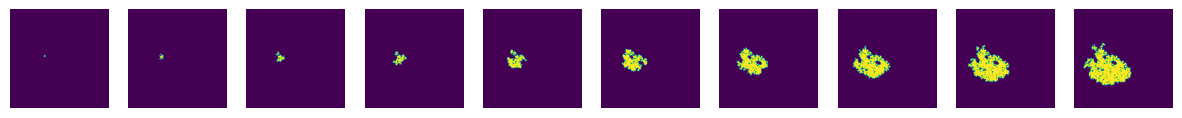

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax[i].imshow(train_data[40, i,:,:])
    ax[i].axis('off')

Train t data shape: (100, 9, 256, 256)
Train t+1 data shape: (100, 9, 256, 256)


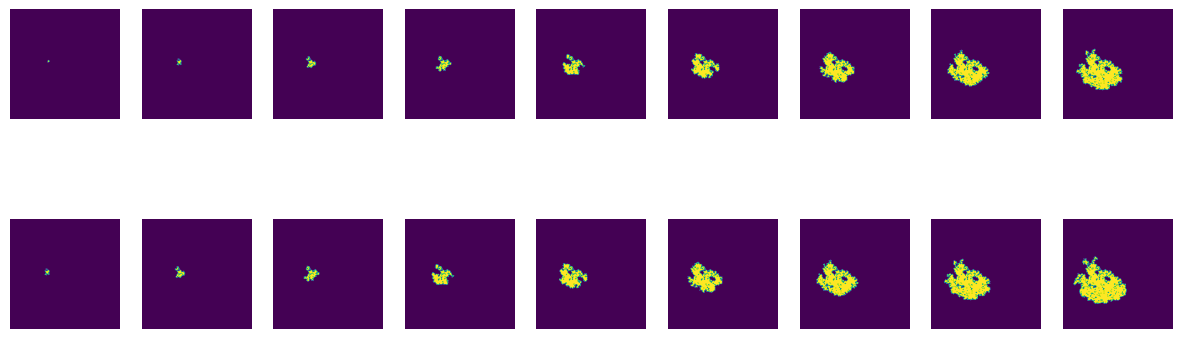

In [8]:
# create t and t+1 data group
def create_data_group(data):
    t_data = data[:, :-1]
    t1_data = data[:, 1:]
    
    return t_data, t1_data

train_t_data, train_t1_data = create_data_group(train_data)
validation_t_data, validation_t1_data = create_data_group(validation_data)

print('Train t data shape:', train_t_data.shape)
print('Train t+1 data shape:', train_t1_data.shape)

fig, ax = plt.subplots(2, 9, figsize=(15, 5))
for i in range(9):
    ax[0, i].imshow(train_t_data[40, i,:,:])
    ax[0, i].axis('off')
    ax[1, i].imshow(train_t1_data[40, i,:,:])
    ax[1, i].axis('off')

### Resizing the images to 64*64
Resizing the images so that training becomes faster

In [6]:
# Function to resize images and add channel dimension
def resize_and_expand_images(data, new_width, new_height):
    num_samples, time_steps, width, height = data.shape
    resized_data = np.zeros((num_samples, time_steps, new_width, new_height, channels))
    for i in range(num_samples):
        for j in range(time_steps):
            img = np.expand_dims(data[i, j], axis=-1)  # Add channel dimension
            resized_img = tf.image.resize(img, [new_width, new_height])
            resized_data[i, j] = resized_img.numpy()
    return resized_data

# Resize the images in the training, validation, and test data
train_data_resized = resize_and_expand_images(train_data, new_width, new_height)
validation_data_resized = resize_and_expand_images(validation_data, new_width, new_height)
test_data_resized = resize_and_expand_images(test_data, new_width, new_height)

# Expected shape after resizing: (num_samples, time_steps, 64, 64, 1)
print('Resized training data shape:', train_data_resized.shape)
print('Resized validation data shape:', validation_data_resized.shape)
print('Resized test data shape:', test_data_resized.shape)

Resized training data shape: (100, 10, 64, 64, 1)
Resized validation data shape: (25, 10, 64, 64, 1)
Resized test data shape: (50, 10, 64, 64, 1)


In [7]:
# Create t and t+1 data groups
def create_data_group(data):
    t_data = data[:, :-1]
    t1_data = data[:, -1]
    return t_data, t1_data

# Create t and t+1 data groups for training and validation data
train_t_data, train_t1_data = create_data_group(train_data_resized)
validation_t_data, validation_t1_data = create_data_group(validation_data_resized)

# Expected shapes:
# train_t_data: (num_samples, time_steps-1, 64, 64, 1)
# train_t1_data: (num_samples, time_steps-1, 64, 64, 1)
print('Train t data shape:', train_t_data.shape)
print('Train t+1 data shape:', train_t1_data.shape)
print('Validation t data shape:', validation_t_data.shape)
print('Validation t+1 data shape:', validation_t1_data.shape)

Train t data shape: (100, 9, 64, 64, 1)
Train t+1 data shape: (100, 64, 64, 1)
Validation t data shape: (25, 9, 64, 64, 1)
Validation t+1 data shape: (25, 64, 64, 1)


#### Creating a Temporal GAN

In a Temporal GAN, the part that functions similarly to the decoder in a Variational Autoencoder (VAE) is the generator. The generator in a Temporal GAN is responsible for producing the next frame in a sequence, given the previous frames as input. This is analogous to the decoder in a VAE, which generates new data points from the latent space representation.

In [10]:
from tensorflow.keras import layers, models

def build_temporal_generator(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(inputs, x, name='temporal_generator')

def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x, name='discriminator')


### Building the model and plotting the loss plots

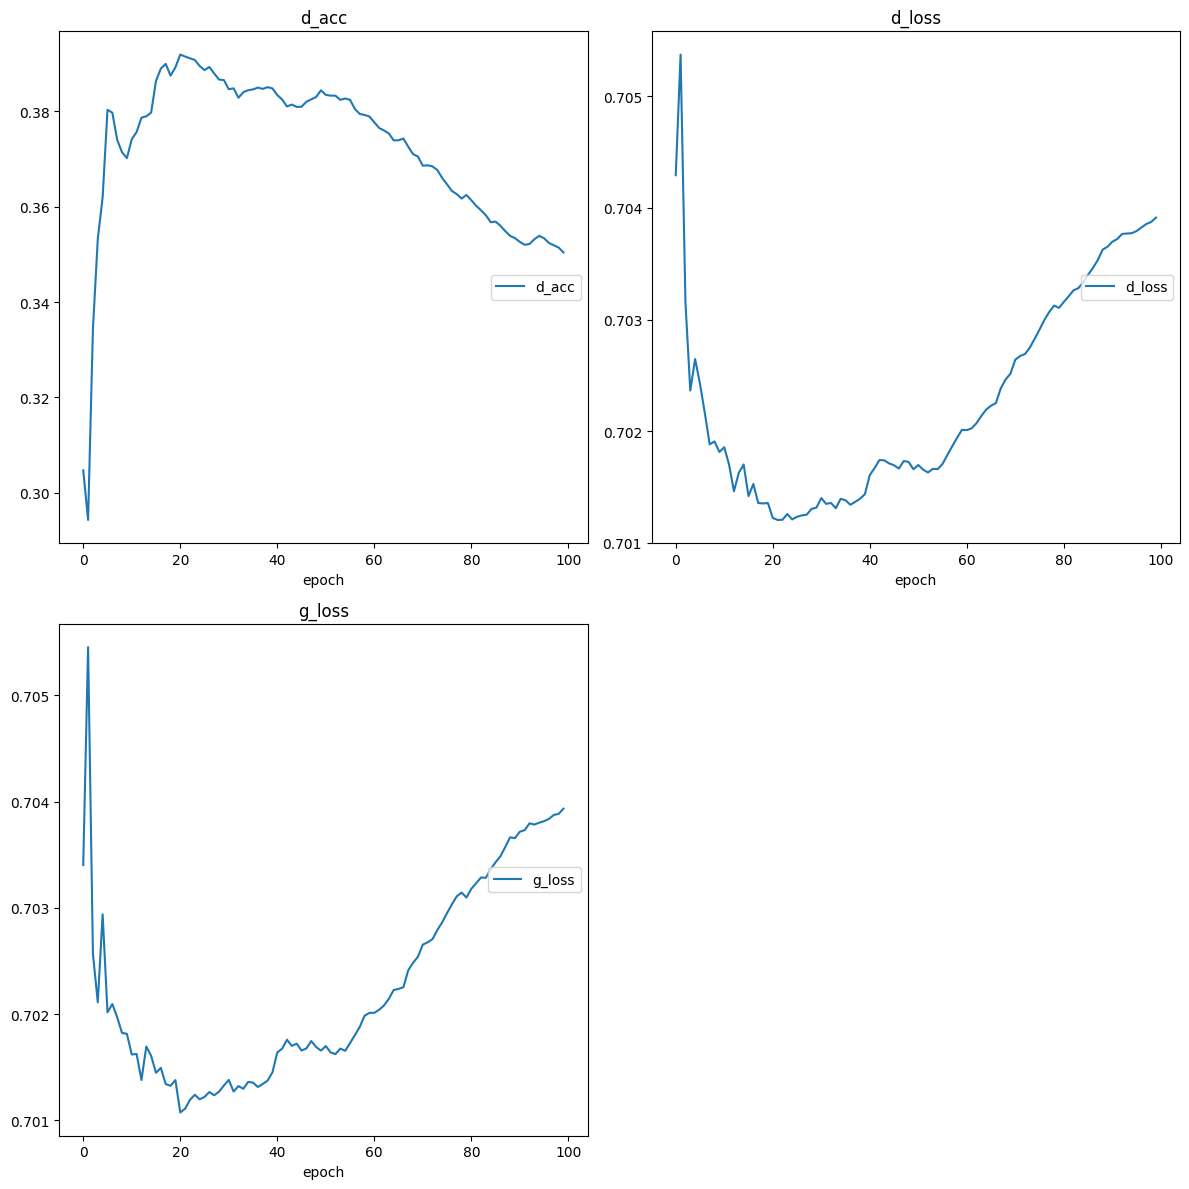

d_acc
	d_acc            	 (min:    0.294, max:    0.392, cur:    0.350)
d_loss
	d_loss           	 (min:    0.701, max:    0.705, cur:    0.704)
g_loss
	g_loss           	 (min:    0.701, max:    0.705, cur:    0.704)


In [11]:
from livelossplot import PlotLossesKerasTF

def build_gan(generator, discriminator):
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(time_steps - 1, new_width, new_height, channels))
    generated_frame = generator(gan_input)
    gan_output = discriminator(generated_frame)
    gan = models.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# Example shapes, adjust to your data
input_shape = (time_steps - 1, new_width, new_height, channels)

# Build and compile the models
generator = build_temporal_generator(input_shape)
discriminator = build_discriminator((new_width, new_height, channels))
gan = build_gan(generator, discriminator)

# Training parameters
batch_size = 32
epochs = 100

# Initialize the live plot
liveplot = PlotLossesKerasTF()

# Training loop
for epoch in range(epochs):
    # Select a random batch of sequences
    idx = np.random.randint(0, train_t_data.shape[0], batch_size)
    real_seqs = train_t_data[idx]
    real_frames = train_t1_data[idx]

    # Ensure the shapes match the expected input shape
    assert real_seqs.shape == (batch_size, time_steps - 1, new_width, new_height, channels)
    assert real_frames.shape == (batch_size, new_width, new_height, channels)
    
    # Generate a batch of new frames
    generated_frames = generator.predict(real_seqs)

    # Create labels for real and fake frames
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_frames, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_frames, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = gan.train_on_batch(real_seqs, real_labels)

    # Update live plot
    # logs = {'d_loss': d_loss[0], 'd_acc': d_loss[1], 'g_loss': float(g_loss)}
    # liveplot.on_epoch_end(epoch, logs)
    logs = {'d_loss': float(d_loss[0]), 'd_acc': float(d_loss[1]), 'g_loss': float(g_loss[0])}
    liveplot.on_epoch_end(epoch, logs)
    
    # Print the progress
    if epoch % 5 == 0:
        print(f"Epoch {epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

# Complete live plot
liveplot.on_train_end()


### Interpretation

**Discriminator Accuracy (d_acc):**
The discriminator accuracy is relatively low (between 29.4% and 39.2%), which suggests that the discriminator is struggling to differentiate between real and fake samples. Ideally, we would like to see the discriminator accuracy around 50%, indicating a balanced game where the generator is producing realistic samples and the discriminator is equally challenged.

**Discriminator Loss (d_loss):**
The discriminator loss is relatively high (around 0.701 to 0.705), which indicates that the discriminator is not performing well in distinguishing real from fake samples. In a well-trained GAN, the discriminator loss typically decreases and stabilizes at a lower value.

**Generator Loss (g_loss):**
The generator loss is also relatively high (around 0.701 to 0.705). This suggests that the generator is not producing samples that are sufficiently realistic to fool the discriminator.

In [13]:
# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames) ** 2)
print(f"MSE Loss: {mse_loss}")

#

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
MSE Loss: 0.2876162586760642


#### Plotting the next generated image

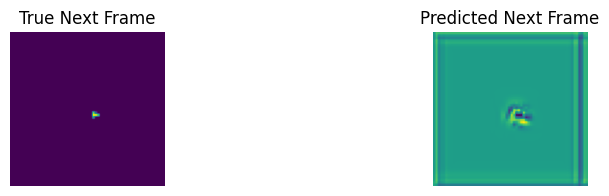

In [41]:
#  Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame")
plt.imshow(predicted_next_frames[0, :, :, 0])
plt.axis('off')

plt.show()

### Adding a threshold to the pixel value to give similar colour image

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
MSE Loss: 0.8415541648864746


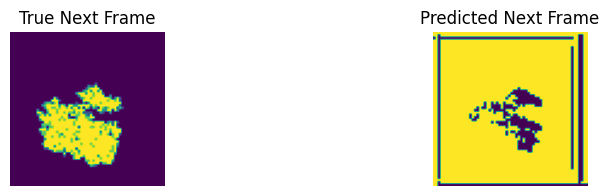

In [44]:
# Function to filter data based on thresholds
def filter_data(data, low_threshold, high_threshold):
    data[data < low_threshold] = 0
    data[data >= high_threshold] = 1
    return data

# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Filter the predicted frames
low_threshold = 0.5
high_threshold = 0.05
predicted_next_frames_filtered = filter_data(predicted_next_frames.copy(), low_threshold, high_threshold)

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames_filtered) ** 2)
print(f"MSE Loss: {mse_loss}")

# Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame")
plt.imshow(predicted_next_frames_filtered[0, :, :, 0])
plt.axis('off')

plt.show()

### Observations:
1. The MSE loss isn't that great: 0.841
2. The next in time image isn't so accurate

# Improving the model

#### Modifications for the Generator
1. Increase Depth:
Added more ConvLSTM2D layers to capture more complex temporal dependencies.

2. Use Residual Connections:
Implemented skip connections to help the model retain information across layers.

3. Feature Expansion:
Increased the number of filters in ConvLSTM2D layers to allow the network to learn more complex features.

In [8]:
def build_temporal_generator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(inputs, x, name='temporal_generator')

#### Modifications for the Discriminator

1. Increase Depth and Filters:
Add more convolutional layers and increase the number of filters to improve the discriminator's capacity to distinguish real from fake frames.

2. Spectral Normalization:
Apply spectral normalization to stabilize the training of the discriminator.

3. Gradient Penalty:
Implement a gradient penalty to improve the training stability of the discriminator.

In [9]:
from tensorflow.keras import layers, models

def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, x, name='discriminator')


### Building the model

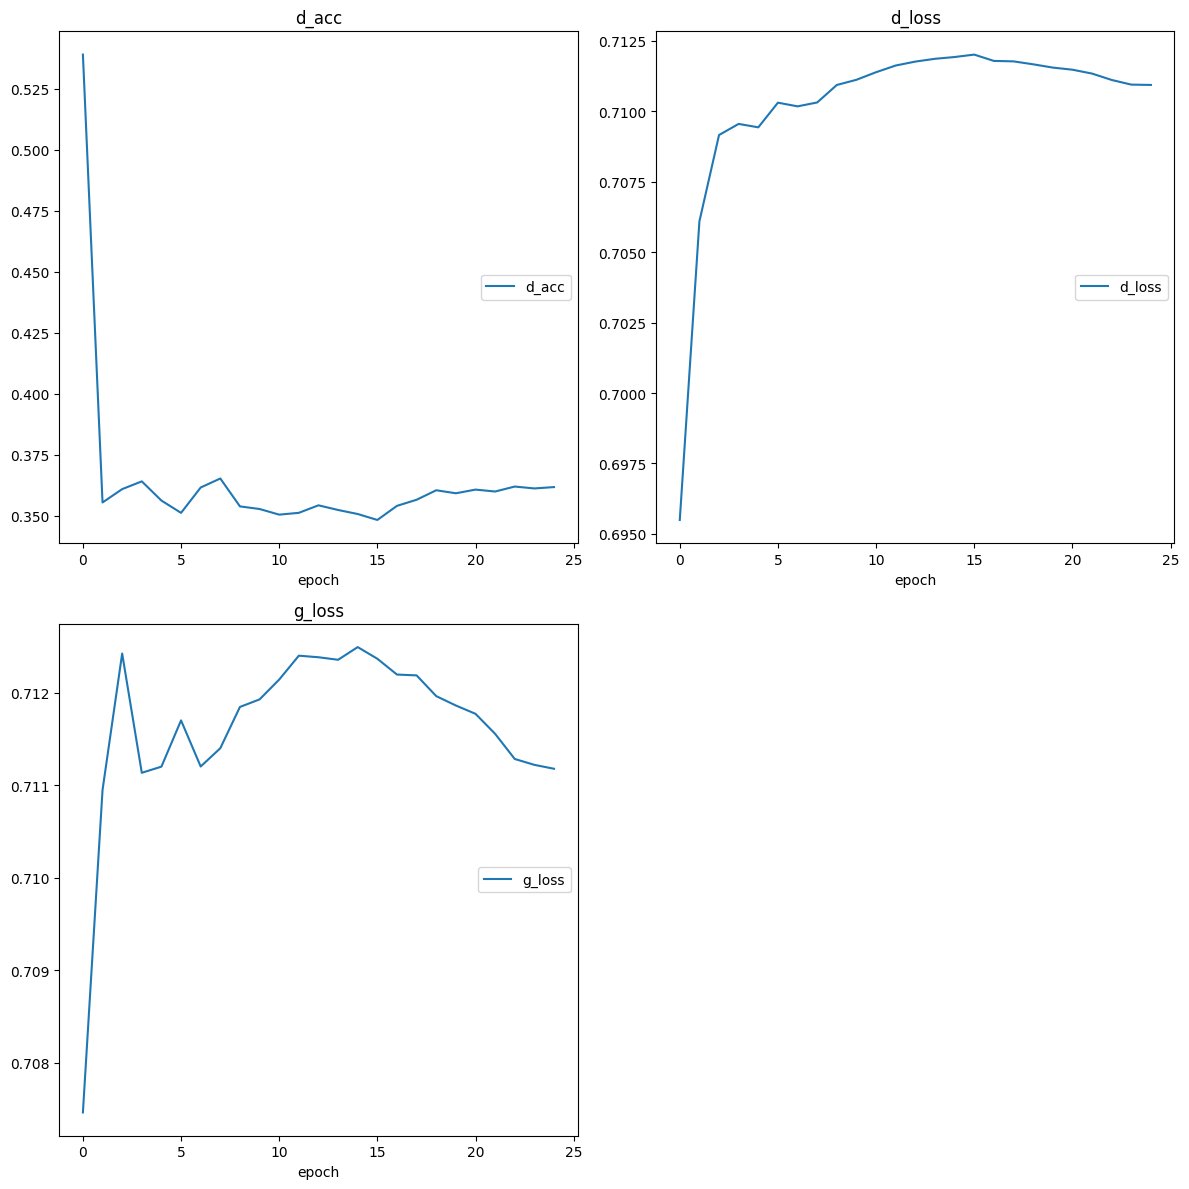

d_acc
	d_acc            	 (min:    0.348, max:    0.539, cur:    0.362)
d_loss
	d_loss           	 (min:    0.695, max:    0.712, cur:    0.711)
g_loss
	g_loss           	 (min:    0.707, max:    0.712, cur:    0.711)


In [10]:
from livelossplot import PlotLossesKerasTF

def build_gan(generator, discriminator):
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(time_steps - 1, new_width, new_height, channels))
    generated_frame = generator(gan_input)
    gan_output = discriminator(generated_frame)
    gan = models.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# Example shapes, adjust to your data
input_shape = (time_steps - 1, new_width, new_height, channels)

# Build and compile the models
generator = build_temporal_generator(input_shape)
discriminator = build_discriminator((new_width, new_height, channels))
gan = build_gan(generator, discriminator)

# Training parameters
batch_size = 32
epochs = 25

# Initialize the live plot
liveplot = PlotLossesKerasTF()

# Training loop
for epoch in range(epochs):
    # Select a random batch of sequences
    idx = np.random.randint(0, train_t_data.shape[0], batch_size)
    real_seqs = train_t_data[idx]
    real_frames = train_t1_data[idx]

    # Ensure the shapes match the expected input shape
    assert real_seqs.shape == (batch_size, time_steps - 1, new_width, new_height, channels)
    assert real_frames.shape == (batch_size, new_width, new_height, channels)
    
    # Generate a batch of new frames
    generated_frames = generator.predict(real_seqs)

    # Create labels for real and fake frames
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_frames, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_frames, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = gan.train_on_batch(real_seqs, real_labels)

    # Update live plot
    # logs = {'d_loss': d_loss[0], 'd_acc': d_loss[1], 'g_loss': float(g_loss)}
    # liveplot.on_epoch_end(epoch, logs)
    logs = {'d_loss': float(d_loss[0]), 'd_acc': float(d_loss[1]), 'g_loss': float(g_loss[0])}
    liveplot.on_epoch_end(epoch, logs)
    
    # Print the progress
    if epoch % 5 == 0:
        print(f"Epoch {epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

# Complete live plot
liveplot.on_train_end()


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
MSE Loss: 0.25169947410603855


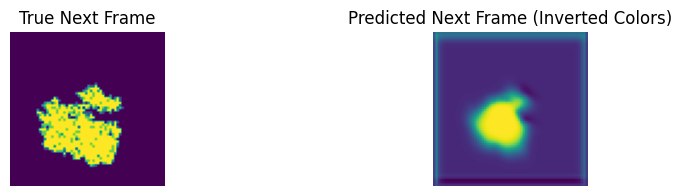

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames) ** 2)
print(f"MSE Loss: {mse_loss}")

# Invert the colors of the predicted next frame
predicted_next_frames_inverted = 1 - predicted_next_frames

# Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame (with inverted colors)
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame (Inverted Colors)")
plt.imshow(predicted_next_frames_inverted[0, :, :, 0])
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
MSE Loss: 0.25922702522780783


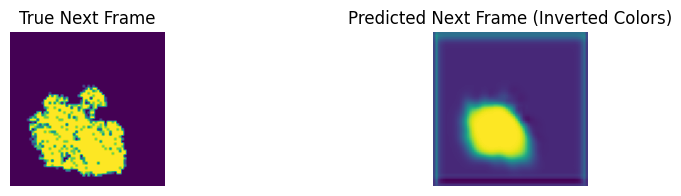

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames) ** 2)
print(f"MSE Loss: {mse_loss}")

# Invert the colors of the predicted next frame
predicted_next_frames_inverted = 1 - predicted_next_frames

# Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame (with inverted colors)
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame (Inverted Colors)")
plt.imshow(predicted_next_frames_inverted[0, :, :, 0])
plt.axis('off')

plt.show()


### Contrast Adjustment

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
MSE Loss: 0.07945038370405808


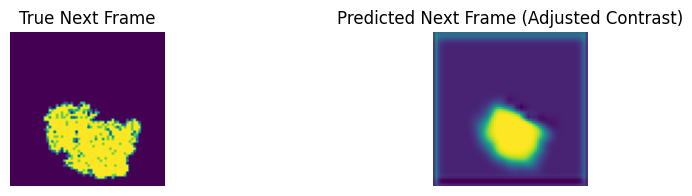

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# Function to apply contrast adjustment
def adjust_contrast(image, low_percentile, high_percentile):
    p2, p98 = np.percentile(image, (low_percentile, high_percentile))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

# Calculate MSE Loss and Generate Next Image
# Select a random batch of sequences from the validation set for testing
idx = np.random.randint(0, validation_t_data.shape[0], batch_size)
test_seqs = validation_t_data[idx]
true_next_frames = validation_t1_data[idx]

# Generate the next frames using the trained generator
predicted_next_frames = generator.predict(test_seqs)

# Invert the colors of the predicted next frame
predicted_next_frames_inverted = 1 - predicted_next_frames

# Adjust the contrast of the predicted next frame
low_percentile = 2
high_percentile = 98
predicted_next_frames_contrast_adjusted = np.zeros_like(predicted_next_frames_inverted)
for i in range(predicted_next_frames_inverted.shape[0]):
    adjusted_image = adjust_contrast(predicted_next_frames_inverted[i, :, :, 0], low_percentile, high_percentile)
    predicted_next_frames_contrast_adjusted[i, :, :, 0] = adjusted_image

# Calculate MSE loss
mse_loss = np.mean((true_next_frames - predicted_next_frames_contrast_adjusted) ** 2)
print(f"MSE Loss: {mse_loss}")

# Plot the true and predicted next frame for the first sequence in the batch
plt.figure(figsize=(10, 2))

# True next frame
plt.subplot(1, 2, 1)
plt.title("True Next Frame")
plt.imshow(true_next_frames[0, :, :, 0])
plt.axis('off')

# Predicted next frame (with inverted colors and adjusted contrast)
plt.subplot(1, 2, 2)
plt.title("Predicted Next Frame (Adjusted Contrast)")
plt.imshow(predicted_next_frames_contrast_adjusted[0, :, :, 0])
plt.axis('off')

plt.show()


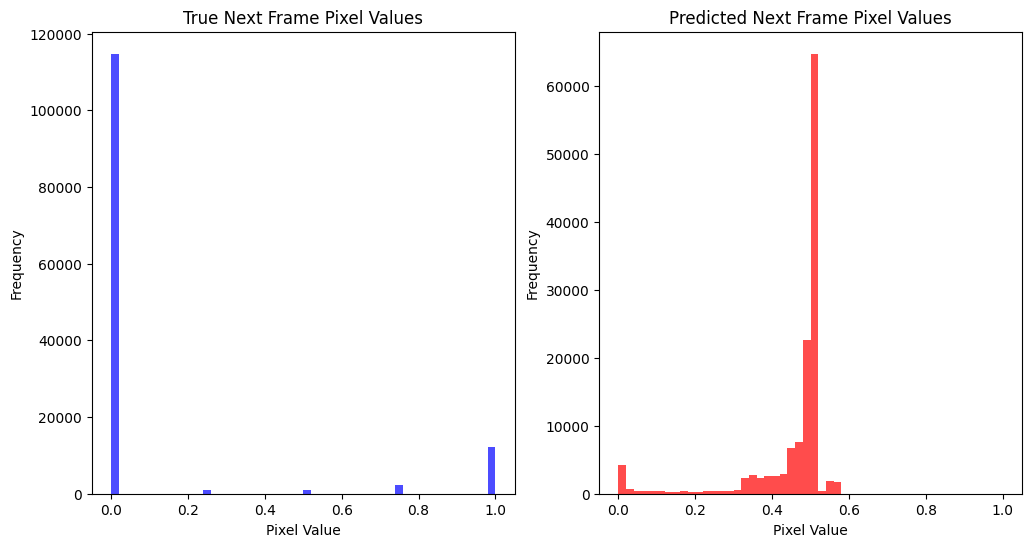

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate pixel value distributions
true_pixel_values = true_next_frames.flatten()
predicted_pixel_values = predicted_next_frames.flatten()

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_pixel_values, bins=50, range=[0, 1], color='blue', alpha=0.7)
plt.title('True Next Frame Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predicted_pixel_values, bins=50, range=[0, 1], color='red', alpha=0.7)
plt.title('Predicted Next Frame Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.show()


In [19]:
print('Train t data shape:', train_t_data.shape)  # Should be (num_samples, time_steps - 1, new_width, new_height, channels)
print('Train t+1 data shape:', train_t1_data.shape)  # Should be (num_samples, new_width, new_height, channels)


Train t data shape: (100, 9, 256, 256, 1)
Train t+1 data shape: (100, 256, 256, 1)
